# Pretrained word embeddings - FastText

In [47]:
import numpy as np
import pandas as pd
import os, re, codecs

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, GRU
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping


### Parsing the FastText word-embeddings file

In [2]:
# Load FastText embeddings
print('Loading word embeddings...')

embeddings_index = {}
f = codecs.open('./wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors' % len(embeddings_index))

Loading word embeddings...


999995it [01:57, 8490.20it/s]


Found 999995 word vectors


### Load data

In [3]:
data_dir = "../dlnn/datasets"

In [4]:
df = pd.read_csv(os.path.join(data_dir, "df_final.csv"))

### Tokenizing the text

In [37]:
df_X = df["comment_text"]
df_Y = df["target_dis"]

In [31]:
df['doc_len'] = df['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
max_seq_len = 80 # Hard-coded: changed from 100 to 80 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2)

In [34]:
maxwords = 100000

In [35]:
tokenizer = Tokenizer(num_words = maxwords)# Creates a tokenizer, configured to only take into account the 1,000 most common words
tokenizer.fit_on_texts(df_X)# Builds the word index

train_samples = tokenizer.texts_to_sequences(X_train)# Turn strings into lists of integer indices
test_samples = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  302139


In [38]:
train_data = pad_sequences(train_samples, padding='post', maxlen=max_seq_len)# Turns the lists of integers into a 2D tensor of shape (samples, maxlen)
test_data = pad_sequences(test_samples, padding='post', maxlen=max_seq_len)

### Training and model parameters

In [40]:
# Training params
batch_size = 256
epochs = 8

# Model parameters
# Convolution
num_filters = 64
kernel_size = 7
embed_dim = 300
weight_decay = 1e-4
pool_size = 4

# LSTM
lstm_output_size = 100

### Preparing the FastText word-embeddings matrix

In [41]:
print('Preparing embedding matrix...')

words_not_found = []
nb_words = min(maxwords, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
        
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix...
number of null word embeddings: 32673


In [44]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['kwh3' 'raif' '“instead' "get'cha" "musk's"
 '221d2ef086b6a0532ab7221d2ef086b6a0532ab7' 'uppance' "bans'" "war'"
 "servant's"]


In [45]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0897    ,  0.016     , -0.0571    , ...,  0.1559    ,
        -0.0254    , -0.0259    ],
       [ 0.0495    ,  0.0411    ,  0.0041    , ...,  0.23710001,
        -0.0298    , -0.0284    ],
       ...,
       [ 0.0505    ,  0.0786    ,  0.069     , ...,  0.192     ,
        -0.0392    , -0.0477    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0394    ,  0.0791    ,  0.12989999, ...,  0.0981    ,
         0.1227    ,  0.0346    ]])

### Custom metrics:  f1_score, precision, recall

In [50]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Defining and training a model

In [70]:
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(input_dim=nb_words, output_dim=embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
    model_conv.add(Dropout(0.5))
    model_conv.add(Conv1D(64, 3, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(Bidirectional(GRU(128)))
    model_conv.add(Dropout(0.5)) # **** considerar
    model_conv.add(Dense(1, activation='sigmoid'))
    
    model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])
    return model_conv

model = create_conv_model()
model.summary()
hist = model.fit(train_data, y_train, batch_size=batch_size, epochs=50, validation_split=0.1, shuffle=True, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 300)           30000000  
_________________________________________________________________
dropout_7 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 78, 64)            57664     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               148224    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total para

Epoch 34/50
 - 211s - loss: 0.4825 - acc: 0.7665 - f1_m: 0.7578 - precision_m: 0.7858 - recall_m: 0.7334 - val_loss: 0.4866 - val_acc: 0.7669 - val_f1_m: 0.7670 - val_precision_m: 0.7682 - val_recall_m: 0.7672
Epoch 35/50
 - 211s - loss: 0.4825 - acc: 0.7663 - f1_m: 0.7576 - precision_m: 0.7854 - recall_m: 0.7335 - val_loss: 0.4839 - val_acc: 0.7669 - val_f1_m: 0.7641 - val_precision_m: 0.7745 - val_recall_m: 0.7555
Epoch 36/50
 - 211s - loss: 0.4820 - acc: 0.7666 - f1_m: 0.7578 - precision_m: 0.7857 - recall_m: 0.7335 - val_loss: 0.4869 - val_acc: 0.7671 - val_f1_m: 0.7668 - val_precision_m: 0.7691 - val_recall_m: 0.7661
Epoch 37/50
 - 210s - loss: 0.4822 - acc: 0.7665 - f1_m: 0.7578 - precision_m: 0.7854 - recall_m: 0.7337 - val_loss: 0.4861 - val_acc: 0.7683 - val_f1_m: 0.7620 - val_precision_m: 0.7842 - val_recall_m: 0.7426
Epoch 38/50
 - 211s - loss: 0.4819 - acc: 0.7667 - f1_m: 0.7578 - precision_m: 0.7862 - recall_m: 0.7331 - val_loss: 0.4862 - val_acc: 0.7669 - val_f1_m: 0.7683

### Evaluate model

In [75]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_data, y_test, verbose=0)

In [76]:
loss

0.4943623340756015

In [77]:
accuracy

0.7635342800529595

In [78]:
f1_score

0.7614370718504838

In [79]:
precision

0.7548161656388934

### Save whatever model

In [63]:
model.save("CNN_FastText.h5")
print("Saved model to disk")

Saved model to disk


### Plot model results

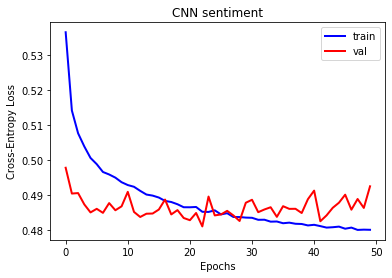

In [71]:
import matplotlib.pyplot as plt

#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

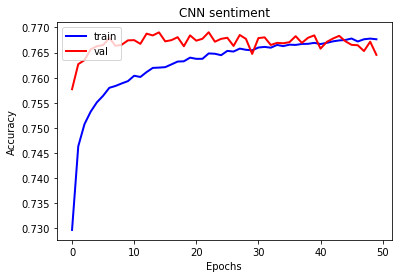

In [72]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(loc='upper left')
plt.show()

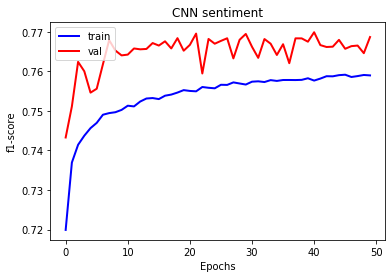

In [73]:
plt.figure()
plt.plot(hist.history['f1_m'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_f1_m'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend(loc='upper left')
plt.show()